Dataset counts: {'train': 3998, 'val': 969, 'test': 969}
Train label distribution: {'transmission with teeth-uncompleted gears': 1812, 'oval gear': 1108, 'spatial slider crank mechanism': 376, 'parallelogram mechanism': 296, 'one way clutch': 154, 'ratchet mechanism': 136, 'chain drive': 94, 'pin rack drive': 22}
Val label distribution: {'transmission with teeth-uncompleted gears': 610, 'oval gear': 201, 'parallelogram mechanism': 59, 'one way clutch': 34, 'chain drive': 28, 'spatial slider crank mechanism': 17, 'pin rack drive': 10, 'ratchet mechanism': 10}
Test label distribution: {'transmission with teeth-uncompleted gears': 608, 'oval gear': 210, 'parallelogram mechanism': 52, 'one way clutch': 32, 'spatial slider crank mechanism': 22, 'ratchet mechanism': 22, 'chain drive': 21, 'pin rack drive': 2}
Class weights: [0.2758002281188965, 0.4510379135608673, 3.6746323108673096, 1.6883445978164673, 1.3291223049163818, 5.316489219665527, 3.2451298236846924, 22.715909957885742]
Epoch 1: T

C:\Users\shrin\AppData\Local\Temp\ipykernel_936\1649233157.py:227: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_locat

Test Loss: 0.8900
Test Accuracy: 0.6584
Precision: 0.7780, Recall: 0.6584, F1: 0.6921
Confusion Matrix:
 [[394  36  21 125   6  15   9   2]
 [ 33 128  23  13   0   8   2   3]
 [  3   2  17   0   0   0   0   0]
 [  8   1   0  43   0   0   0   0]
 [  6   1   0   4  11   0   0   0]
 [  1   0   0   0   0  20   0   0]
 [  4   3   1   0   0   0  24   0]
 [  1   0   0   0   0   0   0   1]]


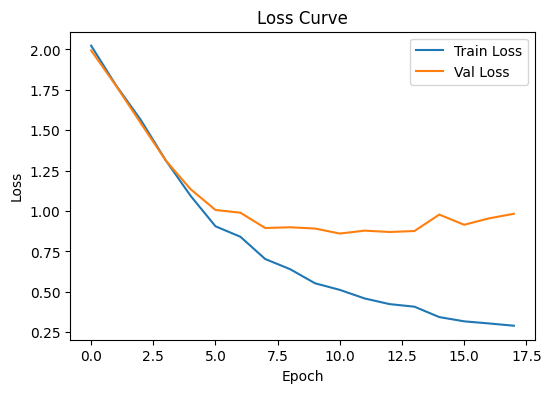

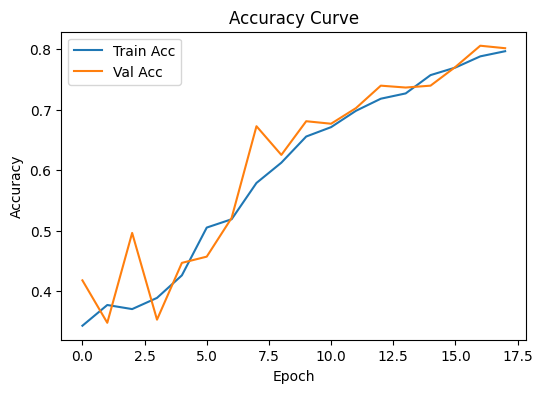

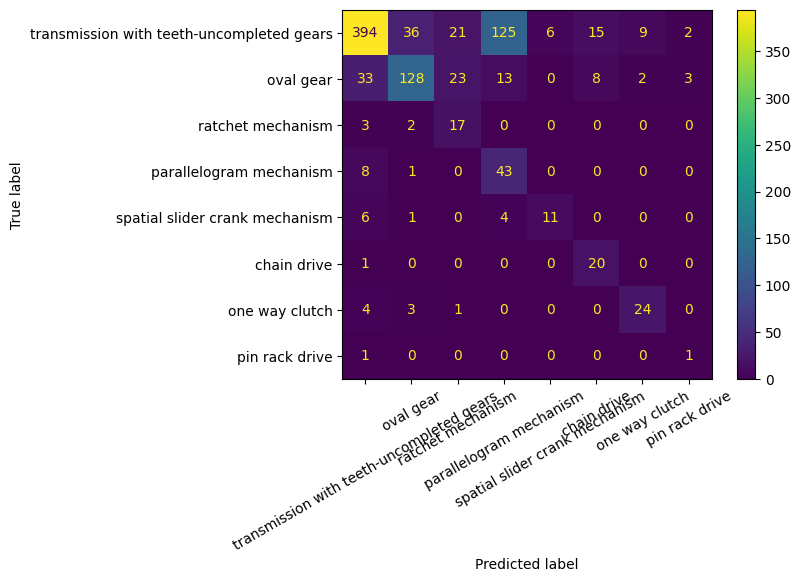

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
Total Parameters: 9,801,994.0
GFLOPS: 0.70


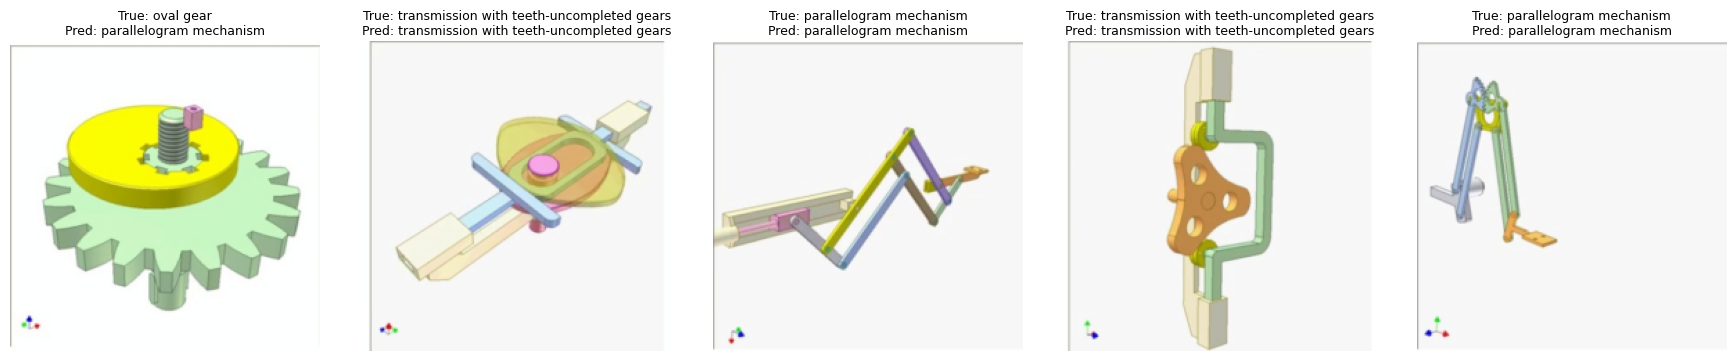

In [4]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt

# =========================================================
# 1. Load CSV and Folder Paths
# =========================================================
metadata_path = r"C:\Users\shrin\OneDrive\Desktop\AS1\_2_dataset.csv"
data_root     = r"C:\Users\shrin\OneDrive\Desktop\AS1\_2_dataset"

train_dir = os.path.join(data_root, "train")
val_dir   = os.path.join(data_root, "val")
test_dir  = os.path.join(data_root, "test")

df = pd.read_csv(metadata_path)

# Filter for 3D images
df = df[df["Sketch Type"].str.contains("3D", case=False, na=False)].reset_index(drop=True)
assert len(df) > 0, "No rows with Sketch Type == '3D' found!"

# Encode classes
class2idx = {c: i for i, c in enumerate(df['Class'].unique())}
idx2class = {i: c for c, i in class2idx.items()}
df['class_idx'] = df['Class'].map(class2idx)
num_classes = len(class2idx)

# Use existing split column from Excel
train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "val"].reset_index(drop=True)
test_df  = df[df["split"] == "test"].reset_index(drop=True)

# Count images in each split
train_count = len(os.listdir(train_dir))
val_count = len(os.listdir(val_dir))
test_count = len(os.listdir(test_dir))
print("Dataset counts:", {"train": train_count, "val": val_count, "test": test_count})

# Verify that all files exist and check for corrupt images
for idx, row in df.iterrows():
    fname = row['File Name']
    split = row['split']
    img_path = os.path.join(train_dir if split == 'train' else val_dir if split == 'val' else test_dir, fname)
    if not os.path.exists(img_path):
        print(f"Warning: {split} image not found - {fname}")
    else:
        try:
            Image.open(img_path).convert('RGB').verify()
        except Exception as e:
            print(f"Warning: Corrupt image in {split} - {fname}: {e}")

# Print label distribution for debugging
print("Train label distribution:", train_df['Class'].value_counts().to_dict())
print("Val label distribution:", val_df['Class'].value_counts().to_dict())
print("Test label distribution:", test_df['Class'].value_counts().to_dict())

# =========================================================
# 2. Transforms
# =========================================================
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.15,0.15), scale=(0.9,1.1)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
eval_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# =========================================================
# 3. Custom Dataset Class
# =========================================================
class MechDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fname = self.df.loc[idx, 'File Name']
        img_path = os.path.join(self.img_dir, fname)
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image {fname} not found in {self.img_dir}")

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.df.loc[idx, 'class_idx']
        return image, label

# =========================================================
# 4. Datasets + Loaders
# =========================================================
train_set = MechDataset(train_df, train_dir, transform=train_transform)
val_set   = MechDataset(val_df, val_dir, transform=eval_transform)
test_set  = MechDataset(test_df, test_dir, transform=eval_transform)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=16, shuffle=False)

# =========================================================
# 5. Class weights
# =========================================================
all_train_labels = train_df['class_idx'].values
class_weights = compute_class_weight('balanced', classes=np.unique(all_train_labels), y=all_train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights.tolist())  # Debug class weights

# =========================================================
# 6. Model
# =========================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.efficientnet_b2(weights=models.EfficientNet_B2_Weights.IMAGENET1K_V1)

# Replace classifier head with increased dropout
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),  # Increased dropout
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),  # Increased dropout
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),  # Increased dropout
    nn.Linear(256, num_classes)
)

model = model.to(device)

# =========================================================
# 7. Training setup
# =========================================================
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.7)

best_val_loss = float('inf')
patience = 7
epochs_no_improve = 0
n_epochs = 100

train_losses, val_losses, train_accs, val_accs = [], [], [], []

# =========================================================
# 8. Training Loop
# =========================================================
for epoch in range(n_epochs):
    model.train()
    running_loss, total, correct = 0, 0, 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
        _, preds = torch.max(out, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)
    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss_sum, val_total, val_correct = 0, 0, 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            out_val = model(X_val)
            loss_val = criterion(out_val, y_val)
            val_loss_sum += loss_val.item() * X_val.size(0)
            _, preds_val = torch.max(out_val, 1)
            val_correct += (preds_val == y_val).sum().item()
            val_total += y_val.size(0)
    val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, "
          f"Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}")

    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

# =========================================================
# 9b. Final Train & Validation Accuracy
# =========================================================
print(f"Final Train Accuracy: {train_accs[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")

# =========================================================
# 9. Test Evaluation
# =========================================================
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()
y_true, y_pred, test_loss_sum, test_total = [], [], 0, 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        out = model(X)
        loss = criterion(out, y)
        test_loss_sum += loss.item() * X.size(0)
        preds = torch.argmax(out, 1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.cpu().numpy())
        test_total += y.size(0)
test_loss = test_loss_sum / test_total

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
conf_mat = confusion_matrix(y_true, y_pred)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print("Confusion Matrix:\n", conf_mat)

# =========================================================
# 10. Plots
# =========================================================
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

# Confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=[idx2class[i] for i in range(len(idx2class))])
disp.plot(xticks_rotation=30)
plt.show()

# =========================================================
# 11. Model Size & FLOPs
# =========================================================
try:
    from thop import profile
    dummy = torch.randn(1,3,224,224).to(device)
    macs, params = profile(model, inputs=(dummy,))
    print(f"Total Parameters: {params:,}")
    print(f"GFLOPS: {macs / 1e9:.2f}")
except Exception as e:
    print("GFLOPS/parameter summary skipped:", e)

# =========================================================
# 12. Sample Predictions
# =========================================================
import random
plt.figure(figsize=(18, 6))  # wider figure to avoid overlap
indices = [0, 1, 2, 3, 4]
for i, idx in enumerate(indices):
    img, label = test_set[idx]
    with torch.no_grad():
        pred = torch.argmax(model(img.unsqueeze(0).to(device))).cpu().item()
    plt.subplot(1, 5, i+1)
    img_for_view = img.numpy().transpose(1,2,0) * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img_for_view = np.clip(img_for_view, 0, 1)
    plt.imshow(img_for_view)
    plt.title(f"True: {idx2class[label]}\nPred: {idx2class[pred]}",
              fontsize=9, wrap=True)  # smaller font + wrap text
    plt.axis('off')

plt.tight_layout(pad=3.0)  # add spacing
plt.show()
